# Activity Coefficients in Electrolyte Solutions
_Mikael Lund, Aug 2016_

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import mdtraj as md
from math import sqrt, pi, exp
import os.path, os, sys, json, filecmp, copy
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir
print(workdir)

/Users/mikael/github/faunus-notebooks/activity-coefficients


### Download and compile the MC software

In [2]:
%%bash -s "$workdir"
%cd -q $1

echo 'fau_example(excess "./" excess.cpp)' > mc/CMakeLists.txt

# the following lines are for compilation on LUNARC
#module add GCC/5.4.0-2.26
#module load CMake/3.5.2
#export CXX=/sw/easybuild/software/Core/GCCcore/5.4.0/bin/g++
#export CC=/sw/easybuild/software/Core/GCCcore/5.4.0/bin/gcc

if [ ! -d "faunus/" ]; then
    git clone https://github.com/mlund/faunus.git
    cd faunus
    git checkout 78e8887749786510f09d265f5ef2651a143a39ce
else
    cd faunus
fi

cmake . -DCMAKE_BUILD_TYPE=Release -DENABLE_APPROXMATH=on -DMYPLAYGROUND=$1/mc &>/dev/null
make excess -j4
%cd $1

[ 36%] Built target xdrfile
[ 81%] Built target libfaunus
[100%] Built target excess


bash: line 1: fg: no job control
bash: line 21: fg: no job control


### Simulation setup
Wall time, number of cores etc. Currently for the slurm system.

In [3]:
%%writefile submit.sh
#!/bin/bash
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -t 03:00:00
../mc/excess > out

Overwriting submit.sh


In [4]:
salts = pd.Series(
    {
        'NaCl_22' : pd.Series(
            dict(ion1='Na', ion2='Cl', n1=1, n2=1, z1=1, z2=-1, r1=2.2, r2=2.2, L=50,
                 activities=np.arange(0.1,1.6,0.1), exp='exp-nacl-coeff.csv', color='red' ) ),
        'Na3Cit_35' : pd.Series(
            dict(ion1='Na', ion2='Cit', n1=3, n2=1, z1=1, z2=-3, r1=2.3, r2=3.5, L=100,
                 activities=np.arange(0.010,0.1,0.01), exp='exp-na3cit-coeff.csv', color='blue' ) )
    }
)

In [5]:
%cd -q $workdir

def mkinput():
    js = {
            "moleculelist": {
                "salt": { "Ninit": 20, "atomic": True, "atoms": d.n1*(d.ion1+' ') + d.n2*(d.ion2+' ') }
            }, 
            "energy": {
                "nonbonded": { "coulomb": { "epsr": 80 } }
            }, 

            "moves": {
                "atomtranslate": { "salt": { "permol": True, "prob": 0.01 } }, 
                "atomgc": { "molecule": "salt" }
            }, 

            "system": {
                "mcloop"      : { "macro": 10, "micro": micro }, 
                "cuboid"      : { "len": d.L },
                "coulomb"     : { "epsr": 80 },
                "temperature" : 298.15
            }, 

            "atomlist": {
                d.ion1: { "q": d.z1, "r": d.r1, "eps":0.01, "dp": 50, "activity": d.n1*activity }, 
                d.ion2: { "q": d.z2, "r": d.r2, "eps":0.01, "dp": 50, "activity": d.n2*activity }
            }
    }

    with open('excess.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))

# flow control:
equilibration = True   # if true, delete state file and start over
production    = True   # if true, start from present state file
slurm         = False  # if true, submit production runs to slurm cluster
override      = False   # if true, override existing files

for salt,d in salts.iteritems():
    for activity in d.activities:
        
        pfx=salt+'-a'+str(activity)
        if not os.path.isdir(pfx):
            %mkdir -p $pfx
        else:
            if override==False:
                break
        %cd $pfx

        # equilibration run
        if equilibration:
            !rm -fR state
            micro=5000
            mkinput()
            !../mc/excess > eq 2>&1
            !rm -fR analysis_out.json

        # production run
        if production:
            micro=10000
            mkinput()
            if slurm:
                !sbatch ../submit.sh > /dev/null
            else:
                !../mc/excess > out 2>&1

        %cd -q ..

print('done.')

done.


### Analysis

The simulation output of the Grand Canonical move statistics contain information about the excess chemical potential and is stored in the file `move_out.json`. In the following we read this data and store it in a Pandas object.

In [6]:
%cd -q $workdir
import json

picklefile = 'data.p' 

if os.path.isfile( picklefile ):        # if pickle file exists, use that
    print('loading from saved pickle')
    sets = pd.read_pickle( picklefile )
else:
    print('loading from MC raw data')   # otherwise extract from MC output

    data = {}
    for salt,d in salts.iteritems():
        d['g1'] = []
        d['g2'] = []
        for activity in d.activities:
            pfx=salt+'-a'+str(activity)
        
            if os.path.isdir(pfx):
                %cd -q $pfx
                r = json.load( open('move_out.json') )['moves']['moves/atomgc']['atoms']
                d['g1'].append( r[d.ion1]['gamma'] )
                d['g2'].append( r[d.ion2]['gamma'] )
                %cd -q ..
    #salts.to_pickle( picklefile )
print(salts.Na3Cit_35)

loading from MC raw data
L                                                           100
activities    [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...
color                                                      blue
exp                                        exp-na3cit-coeff.csv
ion1                                                         Na
ion2                                                        Cit
n1                                                            3
n2                                                            1
r1                                                          2.3
r2                                                          3.5
z1                                                            1
z2                                                           -3
g1            [0.431134515745, 0.326938108085, 0.27509652727...
g2            [0.431134515745, 0.326938108085, 0.27509652728...
dtype: object


### Plot mean activity coefficients

For compound A$_p$B$_q$, the mean ionic activity coefficient is $ \gamma_{\pm} = \sqrt[q+p]{ \gamma_A^p \gamma_B^q}$

(0, 1.6)

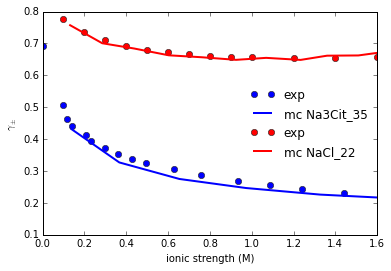

In [9]:
def ionicstrength(c, n1, n2, z1, z2):
    return 0.5*( n1*c*z1**2 + n2*c*z2**2 )

def meanactivity(gA, gB, p, q):
    ''' mean ionic activity coefficitnt'''
    return ( gA**p * gB**q ) ** (1.0/(p+q))

for salt,d in salts.iteritems():
    # experiment
    C, g = np.loadtxt(d.exp, delimiter=',', skiprows=1, unpack=True)
    I = ionicstrength( C, d.n1, d.n2, d.z1, d.z2)
    plt.plot(I, g, marker='o', label='exp', ls='none', color=d.color)
    
    gamma    = meanactivity( np.array(d.g1), np.array(d.g2), d.n1, d.n2 )
    molarity = d.activities / gamma
    I        = ionicstrength(molarity, d.n1, d.n2, d.z1, d.z2)
    
    plt.plot( I, gamma, label='mc '+salt, lw=2, color=d.color)

plt.legend(loc=0, frameon=False)
plt.ylabel('$\gamma_{\pm}$')
plt.xlabel('ionic strength (M)')
plt.xlim(0,1.6)

### Pair potential between ions

The MC simulation uses a pair potential that is a mix of Lennard-Jones plus a Coulomb interaction with a high dielectric background. The particle radii are therefore _not_ just the normal interpretation as in LJ as is illustrated for the distance of closest approach between a cation and anion below.

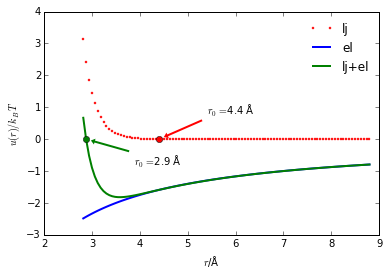

In [8]:
from scipy.optimize import newton

lB=7           # Bjerrum length (Å)
s=2*2.2        # sigma (Å)
eps=0.01 / 2.5 # epsilon (kT)
r = np.linspace(0.64*s, 2*s, 100)

def el(r): return -lB/r                        # Coulomb pot.
def lj(r): return 4*eps*( (s/r)**12-(s/r)**6 ) # Lennard-Jones pot.
def u(r): return lj(r) + el(r)                 # combined pot.

plt.plot(r, lj(r), 'r.', label='lj', markersize=4 )
plt.plot(r, el(r), label='el', lw=2)
plt.plot(r, u(r), label='lj+el', lw=2 )
plt.xlabel(u'$r$/Å')
plt.ylabel(u'$u(r)/k_BT$')
plt.legend(loc=0, frameon=False)

r0 = newton(u, x0=0.5*s) # when is u(r) zero?
plt.plot([r0], [0], 'go')
plt.annotate( '$r_0=$'+str('%.1f' % r0)+u' Å', xy=(r0, 0), xytext=(r0+1, -0.8),
             arrowprops=dict(facecolor='green', width=2, headwidth=6, edgecolor='none', shrink=0.1) )

plt.plot([s], [0], 'ro')
plt.annotate( '$r_0=$'+str('%.1f' % s)+u' Å', xy=(s, 0), xytext=(s+1, 0.8),
             arrowprops=dict(facecolor='red', width=2, headwidth=6, edgecolor='none', shrink=0.1) )